In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
import joblib


          time  y        x1        x2        x3         x4        x5  \
0  5-1-99 0:00  0  0.376665 -4.596435 -4.095756  13.497687 -0.118830   
1  5-1-99 0:02  0  0.475720 -4.542502 -4.018359  16.230659 -0.128733   
2  5-1-99 0:04  0  0.363848 -4.681394 -4.353147  14.127997 -0.138636   
3  5-1-99 0:06  0  0.301590 -4.758934 -4.023612  13.161566 -0.148142   
4  5-1-99 0:08  0  0.265578 -4.749928 -4.333150  15.267340 -0.155314   

          x6        x7        x8  ...        x51        x52       x54  \
0 -20.669883  0.000732 -0.061114  ...  29.984624  10.091721 -4.936434   
1 -18.758079  0.000732 -0.061114  ...  29.984624  10.095871 -4.937179   
2 -17.836632  0.010803 -0.061114  ...  29.984624  10.100265 -4.937924   
3 -18.517601  0.002075 -0.061114  ...  29.984624  10.104660 -4.938669   
4 -17.505913  0.000732 -0.061114  ...  29.984624  10.109054 -4.939414   

         x55        x56       x57       x58       x59       x60  y.1  
0 -24.590146  18.515436  3.473400  0.033444  0.953219  0.

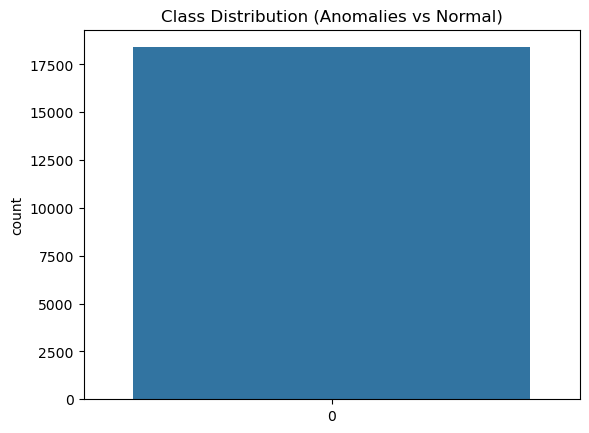

In [2]:
# Load the dataset
data = pd.read_csv('AnomaData.csv')

# Display the first few rows
print(data.head())

# Check for missing values
print(data.isnull().sum())

# Basic statistics
print(data.describe())

# Class distribution
print(data['y'].value_counts())
sns.countplot(data['y'])
plt.title("Class Distribution (Anomalies vs Normal)")
plt.show()


In [3]:
# Check data types of all columns
print(data.dtypes)

# Find columns that are not numeric
non_numeric_cols = data.select_dtypes(exclude=[np.number]).columns
print("Non-numeric columns:", non_numeric_cols)


time     object
y         int64
x1      float64
x2      float64
x3      float64
         ...   
x57     float64
x58     float64
x59     float64
x60     float64
y.1       int64
Length: 62, dtype: object
Non-numeric columns: Index(['time'], dtype='object')


In [4]:
# Convert date columns to datetime, if applicable
if 'date_column_name' in data.columns:
    data['date_column_name'] = pd.to_datetime(data['date_column_name'], errors='coerce')

# Drop or encode categorical columns
for col in non_numeric_cols:
    if data[col].nunique() < 10:  # If few unique values, use one-hot encoding
        data = pd.get_dummies(data, columns=[col], drop_first=True)
    else:  # If many unique values, use label encoding
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col].astype(str))


In [5]:
# Fill missing values with column mean
data.fillna(data.mean(), inplace=True)


In [6]:
# Confirm all columns are numeric
print(data.dtypes)

# Check for any remaining missing values
print(data.isnull().sum())


time      int32
y         int64
x1      float64
x2      float64
x3      float64
         ...   
x57     float64
x58     float64
x59     float64
x60     float64
y.1       int64
Length: 62, dtype: object
time    0
y       0
x1      0
x2      0
x3      0
       ..
x57     0
x58     0
x59     0
x60     0
y.1     0
Length: 62, dtype: int64


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(data.drop(columns=['y']))  # Exclude target column
y = data['y']


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [9]:
# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3655
           1       0.89      0.68      0.77        25

    accuracy                           1.00      3680
   macro avg       0.95      0.84      0.89      3680
weighted avg       1.00      1.00      1.00      3680

ROC AUC Score: 0.9824459644322846


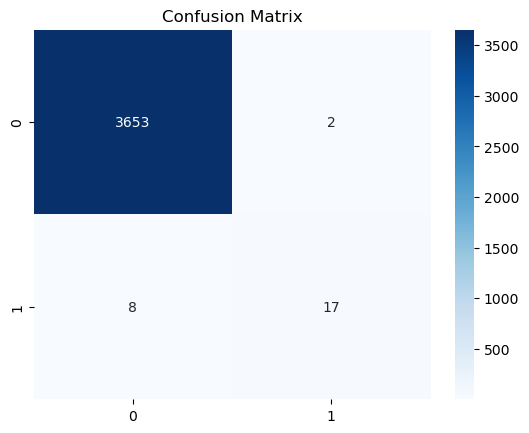

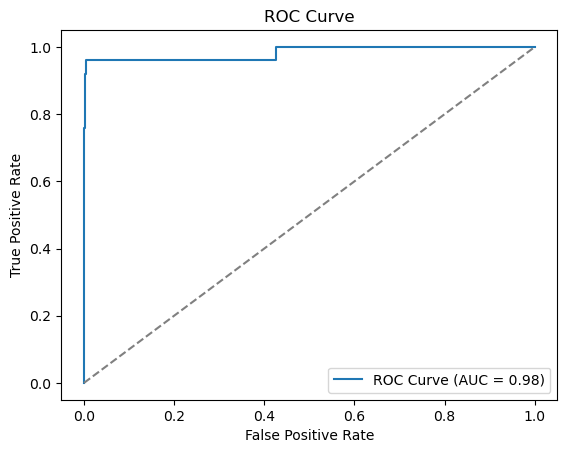

In [10]:
# Predictions
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Performance metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.2f})".format(roc_auc_score(y_test, y_prob)))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [11]:
# Save the trained model
joblib.dump(best_model, 'anomaly_detector_model.pkl')
print("Model saved as 'anomaly_detector_model.pkl'")


Model saved as 'anomaly_detector_model.pkl'


In [12]:
# Load and use the saved model
loaded_model = joblib.load('anomaly_detector_model.pkl')

# Example prediction
sample_data = X_test[0].reshape(1, -1)
prediction = loaded_model.predict(sample_data)
print("Predicted Class:", prediction)


Predicted Class: [0]
